In [ ]:
# Utils
import os
import numpy as np
import pandas as pd
import cv2
from IPython.display import clear_output as cls
import imutils
import zipfile

# Modeling
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D as GAP
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# Visualization
import plotly.express as px
import matplotlib.pyplot as plt

# pre-trained model
from tensorflow.keras.applications import ResNet50V2

In [ ]:
# Unzipping data on Colab
from zipfile import ZipFile

with ZipFile(r'/content/drive/MyDrive/BTD_001.zip') as zipObj:
  zipObj.extractall('/content/drive/MyDrive/Colab Notebooks/BTD_001')

In [ ]:
# defining main directory
main_directory = '/content/drive/MyDrive/Colab Notebooks/BTD_001/'
# checkin classes names
class_names = sorted(os.listdir(main_directory))
# checking number of classes
n_classes = len(class_names)

# class distribution
class_diss = [len(os.listdir(main_directory + name)) for name in class_names]
print(f"Total Number of classes : {n_classes} \nClasse Names : {class_names}")

Total Number of classes : 2 
Classe Names : ['no', 'yes']


In [ ]:
# Visualizing class distribution
fig = px.pie(names=class_names, values=class_diss, title="Class Distribution", hole=0.4)
fig.update_layout({'title':{'x':0.5}})
fig.show()

In [ ]:
def crop_brain_contour(image, plot=False):
    # Convert the image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # Find contours in thresholded image, then grab the largest one
    cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # extreme points
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])

    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]]

    if plot:
        plt.figure()
        plt.subplot(1, 2, 1)
        plt.imshow(image)
        plt.tick_params(axis='both', which='both', top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1, 2, 2)
        plt.imshow(new_image)
        plt.tick_params(axis='both', which='both',top=False, bottom=False, left=False, right=False,labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Cropped Image')
        plt.show()

    return new_image

In [ ]:
# resizing and cropping images
subdir_list = os.listdir(main_directory)

target_size = (630, 630)

for subdir in subdir_list:
    subdir_path = os.path.join(main_directory, subdir)
    if os.path.isdir(subdir_path):
        image_list = os.listdir(subdir_path)
        for image_name in image_list:
            # read image
            image = cv2.imread(os.path.join(subdir_path, image_name))
            # resize image
            image = cv2.resize(image, target_size)
            # crop image
            image = crop_brain_contour(image)
            # replacing the old image in directory
            cv2.imwrite(os.path.join(subdir_path, image_name), image)

In [ ]:
# data loading and augmentation
datagen = ImageDataGenerator(rotation_range=15,
                             width_shift_range=0.05,
                             height_shift_range=0.05,
                             rescale=1./255,
                             shear_range=0.05,
                             brightness_range=[0.1, 1.5],
                             horizontal_flip=True,
                             vertical_flip=True,
                             validation_split=0.1)

# loading training set
train = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='training')

# loading validation set
validation = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='validation')

Found 178 images belonging to 2 classes.
Found 75 images belonging to 2 classes.


In [ ]:
def show_images(GRID= [5,5], model=None, size = (20,20), data=train):
    n_rows = GRID[0]
    n_cols = GRID[1]
    n_images = n_rows * n_cols

    i = 1
    plt.figure(figsize=size)
    for images, labels in data:
        id = np.random.randint(len(images))
        image, label = images[id], class_names[int(labels[id])]
        plt.subplot(n_rows, n_cols, i)
        plt.imshow(image)

        if model is None:
            title = f"Class : {label}"
        else:
            pred = class_names[int(np.argmax(model.predict(image[np.newaxis, ...])))]
            title = f"Org : {label}, Pred : {pred}"
            cls()

        plt.title(title)
        plt.axis('off')

        i+=1
        if i>=(n_images+1):
            break

    plt.tight_layout()
    plt.show()

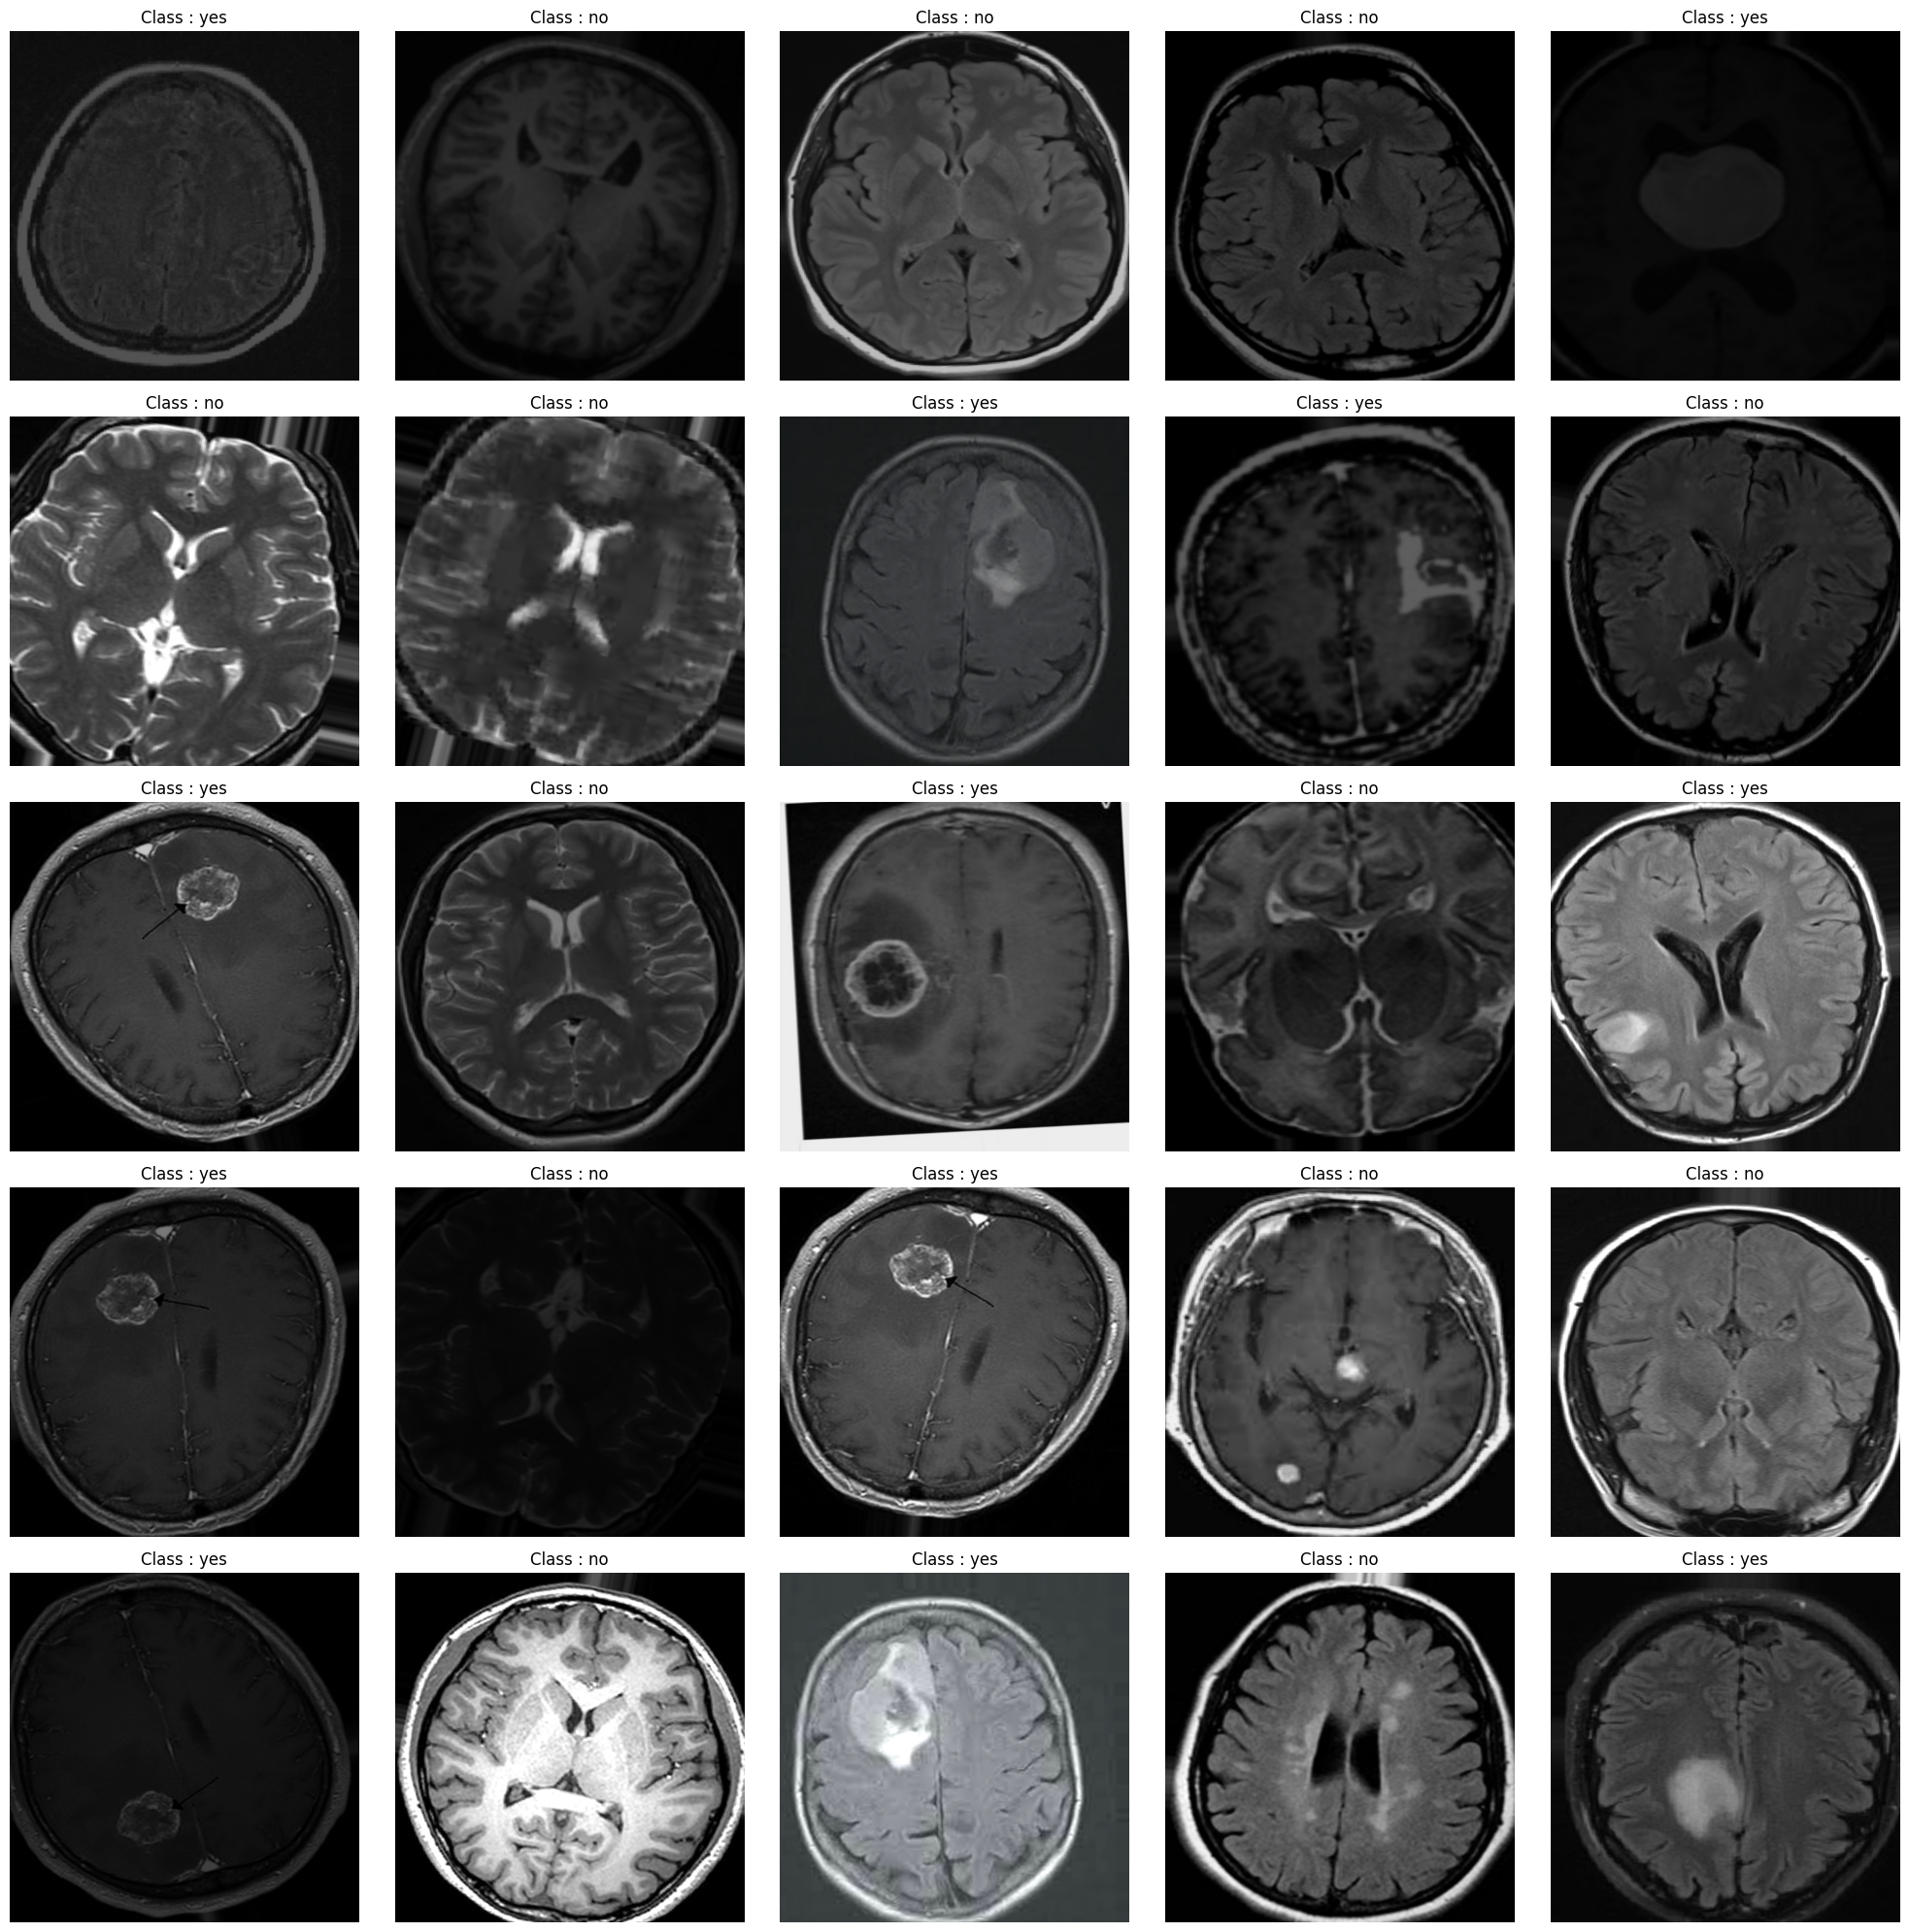

In [ ]:
show_images()

In [ ]:
# defining the base pre-trained model
base_model = ResNet50V2(input_shape=(630,630,3), include_top=False)
base_model.trainable = False

# defining our model
name = "ResNet50V2"
model = Sequential([
    base_model,
    GAP(),
    Dense(256, activation='relu', kernel_initializer='he_normal'),
    Dense(n_classes, activation='softmax'),
], name=name)

# compiling model
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# training model
history = model.fit(train, validation_data=validation, epochs=30)

94668760/94668760 [==============================] - 6s 0us/step
Epoch 1/30
12/12 [==============================] - 49s 3s/step - loss: 1.2247 - accuracy: 0.5899 - val_loss: 0.7499 - val_accuracy: 0.6667
Epoch 2/30
12/12 [==============================] - 29s 2s/step - loss: 0.5746 - accuracy: 0.6910 - val_loss: 0.6210 - val_accuracy: 0.6667
Epoch 3/30
12/12 [==============================] - 29s 2s/step - loss: 0.4524 - accuracy: 0.8371 - val_loss: 0.4231 - val_accuracy: 0.8000
Epoch 4/30
12/12 [==============================] - 29s 2s/step - loss: 0.3663 - accuracy: 0.8427 - val_loss: 0.4362 - val_accuracy: 0.8400
Epoch 5/30
12/12 [==============================] - 29s 2s/step - loss: 0.3534 - accuracy: 0.8596 - val_loss: 0.4196 - val_accuracy: 0.8400
Epoch 6/30
12/12 [==============================] - 30s 2s/step - loss: 0.2676 - accuracy: 0.8933 - val_loss: 0.3825 - val_accuracy: 0.8267
Epoch 7/30
12/12 [==============================] - 29s 2s/step - loss: 0.2943 - accuracy: 0.85

In [ ]:
# train history
data = pd.DataFrame(history.history)
data[-5:]

loss  accuracy  val_loss  val_accuracy
25  0.106098  0.966292  0.283952      0.906667
26  0.117618  0.938202  0.355336      0.840000
27  0.174483  0.932584  0.428031      0.826667
28  0.179018  0.932584  0.352851      0.853333
29  0.155778  0.949438  0.222725      0.906667

In [ ]:
model.summary()

Model: "ResNet50V2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50v2 (Functional)     (None, 20, 20, 2048)      23564800  
                                                                 
 global_average_pooling2d (G  (None, 2048)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 256)               524544    
                                                                 
 dense_1 (Dense)             (None, 2)                 514       
                                                                 
Total params: 24,089,858
Trainable params: 525,058
Non-trainable params: 23,564,800
_________________________________________________________________


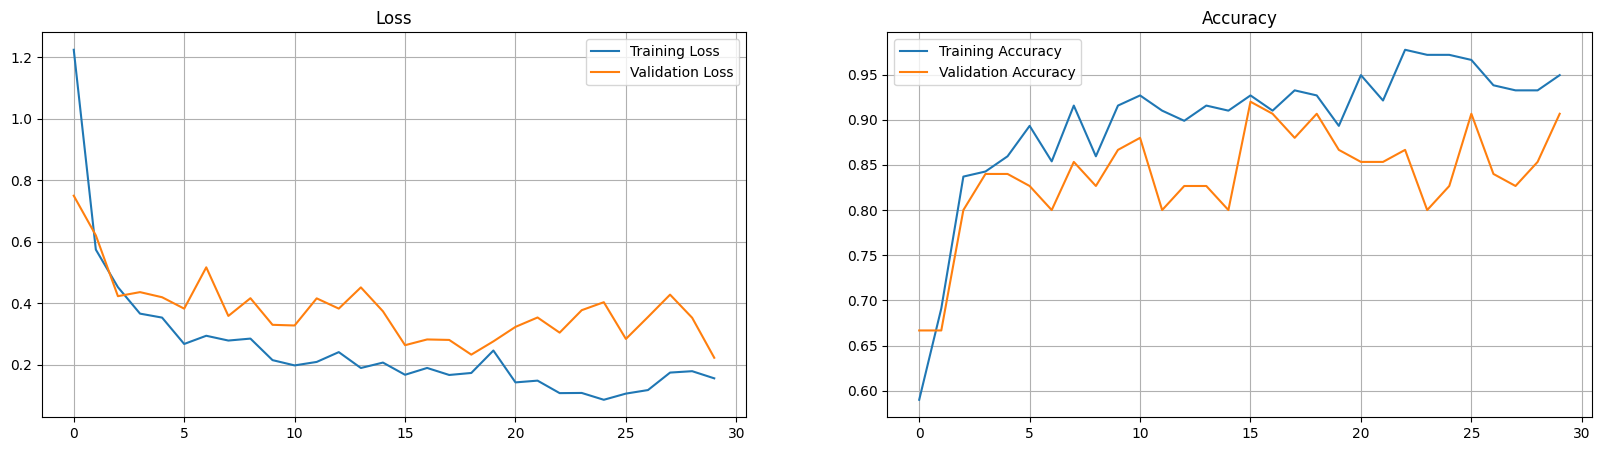

In [ ]:
# plotting training / validation history
plt.figure(figsize=(20,5))

plt.subplot(1,2,1)
plt.plot(data.loss, label='Training Loss')
plt.plot(data.val_loss, label='Validation Loss')
plt.title("Loss")
plt.grid()
plt.legend()

plt.subplot(1,2,2)
plt.plot(data.accuracy, label='Training Accuracy')
plt.plot(data.val_accuracy, label='Validation Accuracy')
plt.title("Accuracy")
plt.grid()
plt.legend()

plt.show()

In [ ]:
# loading training set
train = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='training')

# loading validation set
validation = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='validation')

y_train = train.labels
y_test = validation.labels

# Extracting features from the base model for the train set
X_train_prep = base_model.predict(train)

Found 178 images belonging to 2 classes.
Found 75 images belonging to 2 classes.
12/12 [==============================] - 20s 2s/step


In [ ]:
from tensorflow.keras.applications.resnet_v2 import preprocess_input

# Get the total number of test samples
n_test_samples = validation.samples

# Use the validation data generator to generate the test set
X_test, y_test = validation.next()

# Preprocess the test set
X_test_prep = preprocess_input(X_test)

# Reshape the test set
X_test_prep = X_test_prep.reshape(n_test_samples, -1)

In [ ]:
# loading training set
train = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='training')

# loading validation set
validation = datagen.flow_from_directory(main_directory, class_mode='binary', target_size=(630,630), shuffle=True, batch_size=16,
subset='validation')

y_train = train.labels
y_test = validation.labels

# Extracting features from the base model for the train set
X_train = base_model.predict(train)
X_train_flat = X_train.reshape(X_train.shape[0], -1)

# Extracting features from the base model for the validation set
X_test = base_model.predict(validation)
X_test_flat = X_test.reshape(X_test.shape[0], -1)

from sklearn.svm import SVC

svm_model = SVC(kernel='linear')
svm_model.fit(X_train_flat, y_train)

In [ ]:
score = model.evaluate(validation)
print("Validation accuracy:", score[1])

5/5 [==============================] - 9s 2s/step - loss: 0.2938 - accuracy: 0.9067
Validation accuracy: 0.9066666960716248


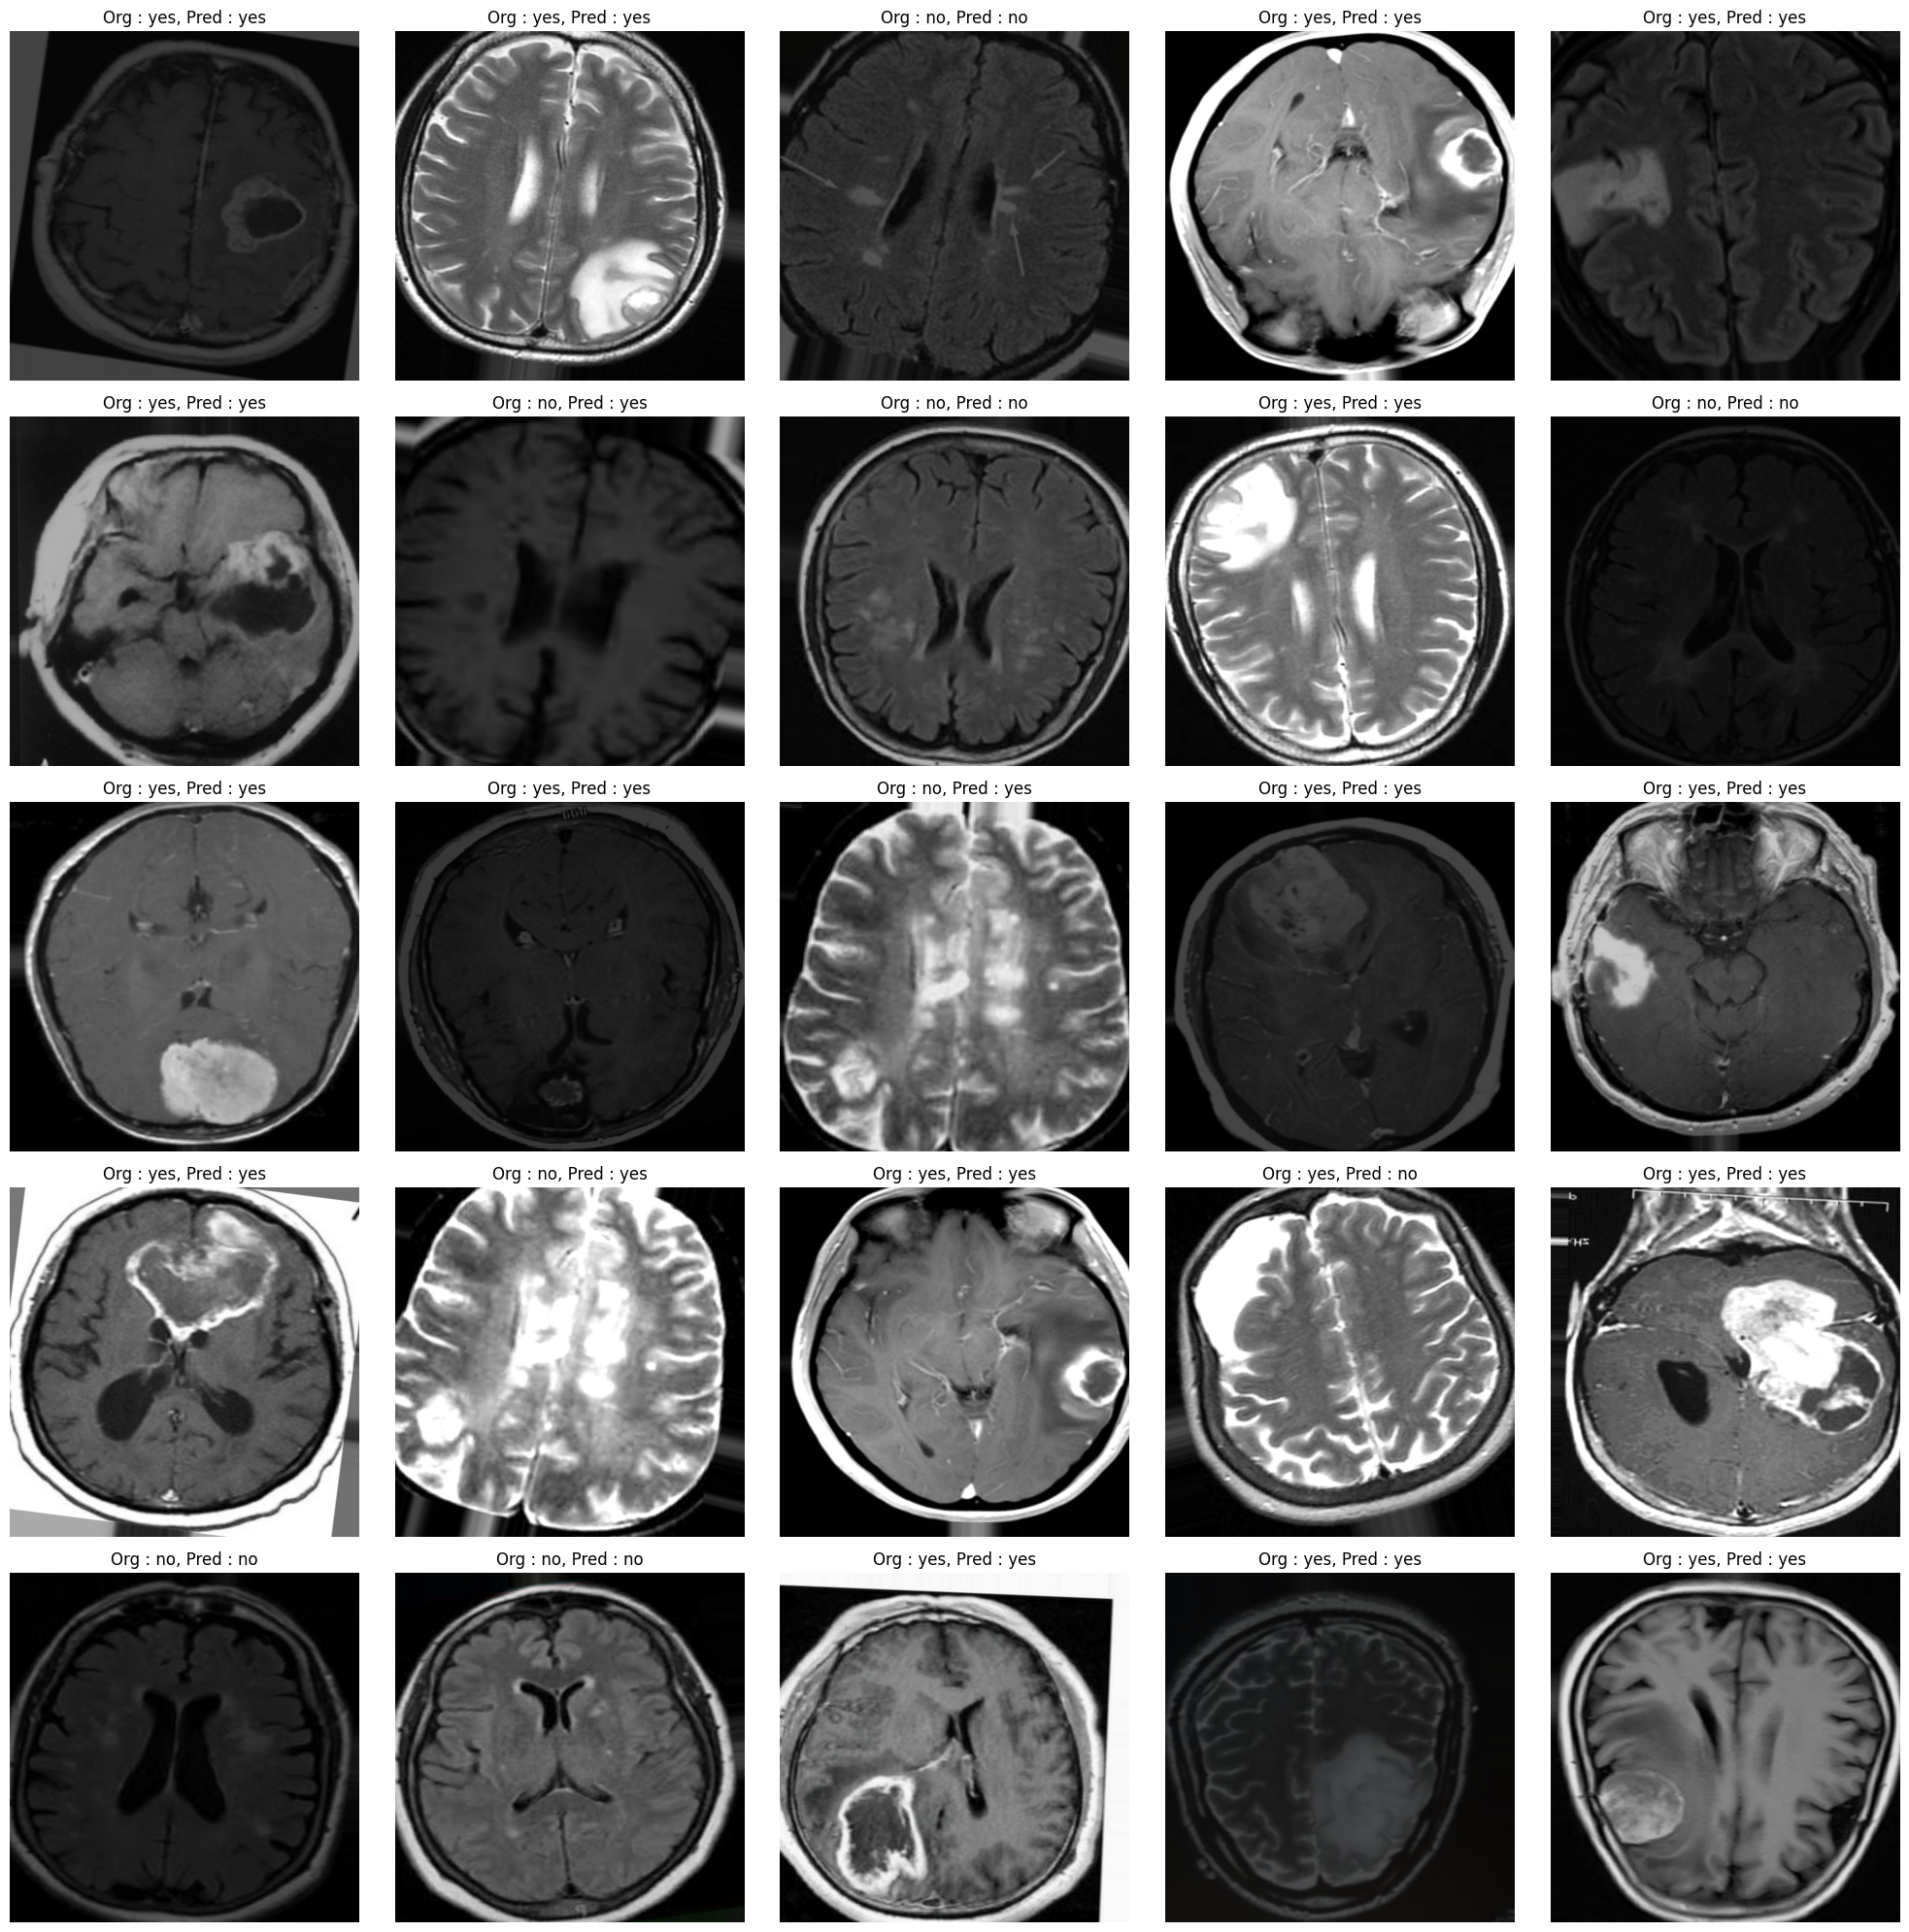

In [ ]:
# plotting predictions
show_images(model=model, data=validation)